## Import Library

In [1]:
import dgl
from dgl.data import DGLDataset
import os
import pandas as pd
import numpy as np
import torch
import itertools
import numpy as np
import scipy.sparse as sp
import dgl.nn as dglnn
import torch.nn as nn
import torch.nn.functional as F
import dgl.function as fn
from dgl.nn.pytorch import conv as dgl_conv
from startup_data_set import COMP4222Dataset
from PredictorClasses import *
from CustomMetrics import *
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
device = torch.device('cpu')

### Hypermeters

In [2]:
val_ratio = 0.1
test_ratio = 0.1

# Hyperparameters
n_hidden = 64
n_layers = 2
dropout = 0.5
aggregator_type = 'mean'

## Load Dataset

In [3]:
dataset = COMP4222Dataset()
graph = dataset[0]
print(graph)

Graph(num_nodes=25446, num_edges=45621,
      ndata_schemes={'feat': Scheme(shape=(221,), dtype=torch.float64), 'label': Scheme(shape=(), dtype=torch.float32)}
      edata_schemes={'feat': Scheme(shape=(23,), dtype=torch.float64)})


In [4]:
in_feats = graph.ndata['feat'].shape[1]

## Generate Postitve Graph and Negative Graph with Spliting

In [18]:
from CustomUtilities import generate_neg_graph, generate_pos_graph
train_g, train_pos_g, val_pos_g, test_pos_g = \
    generate_pos_graph(graph, val_ratio, test_ratio)

train_g

Graph(num_nodes=25446, num_edges=61943,
      ndata_schemes={'feat': Scheme(shape=(221,), dtype=torch.float64), 'label': Scheme(shape=(), dtype=torch.float32)}
      edata_schemes={'feat': Scheme(shape=(23,), dtype=torch.float64)})

In [19]:
train_neg_g, val_neg_g, test_neg_g = \
    generate_neg_graph(graph, val_ratio, test_ratio)

train_neg_g

Graph(num_nodes=25446, num_edges=36497,
      ndata_schemes={}
      edata_schemes={})

## Model Training

### Model Setup

In [20]:
class GraphSAGEModel(nn.Module):
    def __init__(self,
                 in_feats,
                 n_hidden,
                 out_dim,
                 n_layers,
                 activation,
                 dropout,
                 aggregator_type):
        super(GraphSAGEModel, self).__init__()

        self.layers = nn.ModuleList()
        # input layer
        self.layers.append(dgl_conv.SAGEConv(in_feats, n_hidden, aggregator_type,
                                         feat_drop=dropout, activation=activation))
        # hidden layers
        for i in range(n_layers - 1):
            self.layers.append(dgl_conv.SAGEConv(n_hidden, n_hidden, aggregator_type,
                                             feat_drop=dropout, activation=activation))
        # output layer
        self.layers.append(dgl_conv.SAGEConv(n_hidden, out_dim, aggregator_type,
                                         feat_drop=dropout, activation=None))
        
    def forward(self, g, features):
        h = features.float()
        for layer in self.layers:
            h = layer(g, h).float()
        return h

In [21]:
gconv_model = GraphSAGEModel(in_feats,
                             n_hidden,
                             n_hidden,
                             n_layers,
                             F.relu,
                             dropout,
                             aggregator_type)

pred = DotPredictor()

### Training Loop

In [22]:
import itertools

train_loss, val_loss = [], []
train_AUC, val_AUC = [], []
stop = 0

optimizer = torch.optim.Adam(itertools.chain(gconv_model.parameters(), pred.parameters()), lr=0.01)
for e in range(500):
    # forward
    h = gconv_model(train_g, train_g.ndata['feat'])
    pos_score = pred(train_pos_g, h)
    neg_score = pred(train_neg_g, h)
    loss = compute_loss(pos_score, neg_score)
    train_loss.append(loss.item())
    train_AUC.append(compute_auc(pos_score, neg_score))

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # validation
    v_pos_score = pred(val_pos_g, h)
    v_neg_score = pred(val_neg_g, h)
    v_loss = compute_loss(v_pos_score, v_neg_score)
    val_loss.append(v_loss.item())
    val_AUC.append(compute_auc(v_pos_score, v_neg_score))

    #verbose
    if e % 5 == 0:
        print('Epoch: {} \t\t\t Train loss: {} \t\t\t Val loss: {}'.format(e, loss, v_loss))


    # early stopping
    if len(val_loss) > 2 and val_loss[-1] > val_loss[-2]:
        stop += 1
    if stop >= 30:
        print("Early Stopped at Epoch {}".format(e))
        break


Epoch: 0 			 Train loss: 7.524359703063965 			 Val loss: 7.3221964836120605
Epoch: 5 			 Train loss: 0.8489562273025513 			 Val loss: 0.907529890537262
Epoch: 10 			 Train loss: 0.688387393951416 			 Val loss: 0.7049861550331116
Epoch: 15 			 Train loss: 0.688308596611023 			 Val loss: 0.6985816955566406
Epoch: 20 			 Train loss: 0.6889563202857971 			 Val loss: 0.694618284702301
Epoch: 25 			 Train loss: 0.6893947124481201 			 Val loss: 0.6943252682685852
Epoch: 30 			 Train loss: 0.687760055065155 			 Val loss: 0.6942128539085388
Epoch: 35 			 Train loss: 0.6855019927024841 			 Val loss: 0.6926041841506958
Epoch: 40 			 Train loss: 0.6832807660102844 			 Val loss: 0.691194474697113
Epoch: 45 			 Train loss: 0.6790958642959595 			 Val loss: 0.6899121403694153
Epoch: 50 			 Train loss: 0.6753295660018921 			 Val loss: 0.6862536072731018
Epoch: 55 			 Train loss: 0.6678652763366699 			 Val loss: 0.6772948503494263
Epoch: 60 			 Train loss: 0.6610100865364075 			 Val loss: 0.677603662014

In [23]:
# testing AUC
with torch.no_grad():
    pos_score = pred(test_pos_g, h)
    neg_score = pred(test_neg_g, h)
    print('AUC:', compute_auc(pos_score, neg_score))

AUC: 0.761316176500266


### Result Plotting

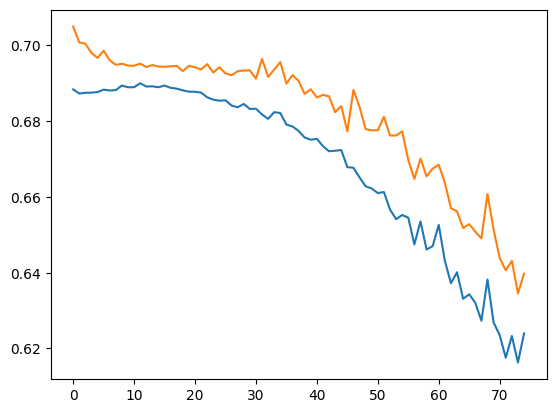

In [24]:

plt.plot(train_loss[10:])
plt.plot(val_loss[10:])

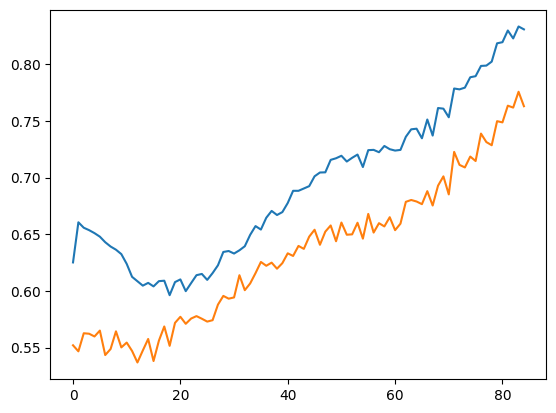

In [25]:
plt.plot(train_AUC)
plt.plot(val_AUC)